In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install bids
!pip install git+https://github.com/npnl/bidsio
import bidsio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 65.1 MB/s 
     |████████████████████████████████| 96 kB 7.1 MB/s 
     |████████████████████████████████| 125 kB 77.8 MB/s 
     |████████████████████████████████| 68 kB 7.7 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=81bd460f8d2a06019f6fd3b3216b0414e0e1c113d3b8fbc4d29a0f5cf0f81765
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.45
    Uninstalling SQLAlchemy-1.4.45:
      Successfully uninstalled SQLAlchemy-1.4.45
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pi

In [4]:
bids_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=5,
                                root_dir='/content/drive/MyDrive/ATLASSTUFF/split1/split1/train/')

In [ ]:
tmp = bids_loader.load_sample(0)
print(f'There are {len(bids_loader)} subjects in our dataset.')
print(f'Every sample loads {len(tmp)} images.')
print(f'Images have these dimensions: {bids_loader.data_shape}')
print(f'Every batch will load {bids_loader.batch_size} samples.')

There are 525 subjects in our dataset.
Every sample loads 2 images.
Images have these dimensions: (197, 233, 189)
Every batch will load 5 samples.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, width_multiplier=1, trilinear=True, use_ds_conv=False):
        """A simple 3D Unet, adapted from a 2D Unet from https://github.com/milesial/Pytorch-UNet/tree/master/unet
        Arguments:
          n_channels = number of input channels; 3 for RGB, 1 for grayscale input
          n_classes = number of output channels/classes
          width_multiplier = how much 'wider' your UNet should be compared with a standard UNet
                  default is 1;, meaning 32 -> 64 -> 128 -> 256 -> 512 -> 256 -> 128 -> 64 -> 32
                  higher values increase the number of kernels pay layer, by that factor
          trilinear = use trilinear interpolation to upsample; if false, 3D convtranspose layers will be used instead
          use_ds_conv = if True, we use depthwise-separable convolutional layers. in my experience, this is of little help. This
                  appears to be because with 3D data, the vast vast majority of GPU RAM is the input data/labels, not the params, so little
                  VRAM is saved by using ds_conv, and yet performance suffers."""
        super(UNet, self).__init__()
        _channels = (32, 64, 128, 256, 512)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channels = [int(c*width_multiplier) for c in _channels]
        self.trilinear = trilinear
        self.convtype = DepthwiseSeparableConv3d if use_ds_conv else nn.Conv3d

        self.inc = DoubleConv(n_channels, self.channels[0], conv_type=self.convtype)
        self.down1 = Down(self.channels[0], self.channels[1], conv_type=self.convtype)
        self.down2 = Down(self.channels[1], self.channels[2], conv_type=self.convtype)
        self.down3 = Down(self.channels[2], self.channels[3], conv_type=self.convtype)
        factor = 2 if trilinear else 1
        self.down4 = Down(self.channels[3], self.channels[4] // factor, conv_type=self.convtype)
        self.up1 = Up(self.channels[4], self.channels[3] // factor, trilinear)
        self.up2 = Up(self.channels[3], self.channels[2] // factor, trilinear)
        self.up3 = Up(self.channels[2], self.channels[1] // factor, trilinear)
        self.up4 = Up(self.channels[1], self.channels[0], trilinear)
        self.outc = OutConv(self.channels[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            conv_type(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            conv_type(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, conv_type=nn.Conv3d):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels, conv_type=conv_type)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        # if trilinear, use the normal convolutions to reduce the number of channels
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, mid_channels=in_channels // 2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class DepthwiseSeparableConv3d(nn.Module):
    def __init__(self, nin, nout, kernel_size, padding, kernels_per_layer=1):
        super(DepthwiseSeparableConv3d, self).__init__()
        self.depthwise = nn.Conv3d(nin, nin * kernels_per_layer, kernel_size=kernel_size, padding=padding, groups=nin)
        self.pointwise = nn.Conv3d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

model = UNet(n_channels=1, n_classes=1)
#model = model.UNet3D(in_channels=1, out_channels=1, num_groups=1, num_levels=2, f_maps=10)

In [6]:
model.load_state_dict(torch.load('drive/MyDrive/ATLASSTUFF/model_weights_osu6.pth'))

<All keys matched successfully>

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [8]:


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [9]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [10]:
#import losses

#loss_func = DiceLoss()
loss_func = DiceBCELoss()

In [11]:
import random
def cubeView(batch, labels, cubeSize, threshold):
  shape = batch.shape
  x_len = shape[2]
  y_len = shape[3]
  z_len = shape[4]
  resultData = torch.empty((shape[0], shape[1], cubeSize, cubeSize, cubeSize))
  resultLabel = torch.empty((shape[0], shape[1], cubeSize, cubeSize, cubeSize))
  for i in range(shape[0]):
    loopB = True
    while(loopB):
      (posx, posy, posz) = random.randint(0, x_len - cubeSize), random.randint(0, y_len - cubeSize), random.randint(0, z_len - cubeSize)
      if (torch.sum(labels[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]) / torch.sum(labels[i,::,::,::,::]) > threshold):
        resultData[i, :, :, :, :] = batch[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]
        resultLabel[i, :, :, :, :] = labels[i,:,posx:posx+cubeSize, posy:posy+cubeSize, posz:posz+cubeSize]
        loopB = False
  return resultData, resultLabel

torch.Size([4, 1, 64, 64, 64])


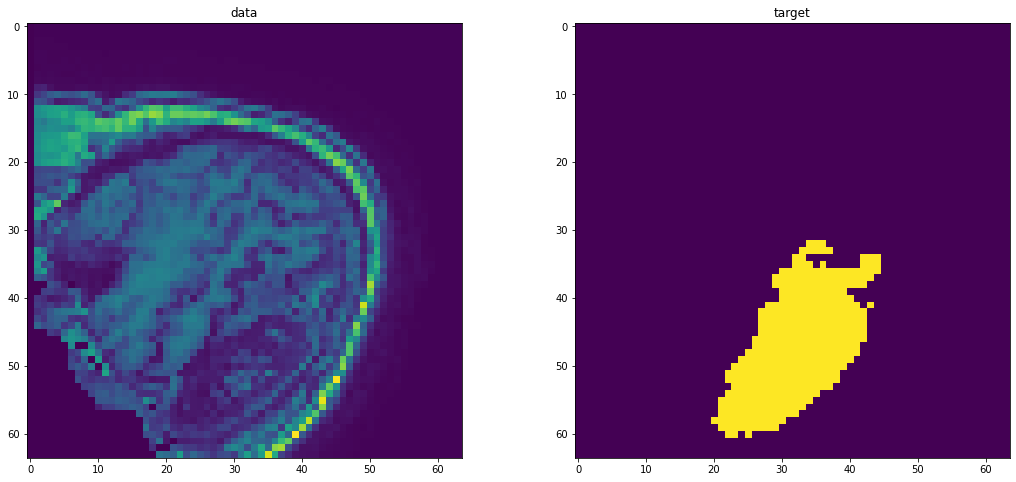

In [ ]:
import matplotlib.pyplot as plt

data, target = next(bids_loader.load_batches())
data = torch.Tensor(data)
target = torch.Tensor(target)

plt.figure(figsize=(18, 8)) 
plt.subplot(121)
plt.imshow(downsize_64(data)[0,0,50]);plt.title('data')
plt.subplot(122)
plt.imshow(downsize_64(target)[0,0,50]);plt.title('target')
print(downsize_64(target).shape)

In [ ]:
import numpy as np
#torch.Size([2, 1, 197, 233, 189])
torch.Size([2, 1, 197, 233, 189])

#xrt = F.pad(data, 2,1,4,3,6,5, "constant", 0)

torch.Size([2, 1, 197, 233, 189])

In [13]:
import matplotlib.pyplot as plt

# model to GPU
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
model.to(device)
#print(data.dtype)
losses = []
dice = []

for epoch in range(100):
    running_loss = 0.0
    i = 0
    for data, label in bids_loader.load_batches():

        #data = np.pad(data, )

        data = torch.Tensor(data)
        label = torch.Tensor(label)

        #data= F.pad(torch.Tensor(data), (2,1,4,3,6,5), "constant", 0)
        #label = F.pad(torch.Tensor(label), (2,1,4,3,6,5), "constant", 0)

        #print(data.shape)
        #print(label.shape)

        data, label = cubeView(data, label, 64, .2)

        #print(data.shape)

        data = data.to(device)
        label = label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        #N, C, H, W = 5, 64, 64, 64
        #data = torch.arange(N*C*H*W).view(N, 1, C, H, W).float()
        #label = torch.arange(N*C*H*W).view(N, 1, C, H, W).float()

        # forward + backward + optimize
        outputs = model(data)
        loss = loss_func(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % 10 == 9):
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10 :.8f}')
          losses.append(running_loss)
          dice.append(DiceLoss(outputs, label))
          running_loss = 0.0
        i += 1
        torch.save(model.state_dict(), 'drive/MyDrive/ATLASSTUFF/model_weights_osu6.pth')


[1,    10] loss: 0.50071821
[1,    20] loss: 0.47376165
[1,    30] loss: 0.84270290
[1,    40] loss: 0.63458056
[1,    50] loss: 0.56794928
[1,    60] loss: 0.42396646
[1,    70] loss: 0.47191744
[1,    80] loss: 0.61879359
[1,    90] loss: 0.43695987
[1,   100] loss: 0.57478795
[2,    10] loss: 0.45432208
[2,    20] loss: 0.46673076
[2,    30] loss: 0.76536824
[2,    40] loss: 0.65913033
[2,    50] loss: 0.59737395
[2,    60] loss: 0.43605665
[2,    70] loss: 0.46951249
[2,    80] loss: 0.60942244
[2,    90] loss: 0.44856251
[2,   100] loss: 0.48827772
[3,    10] loss: 0.44725453
[3,    20] loss: 0.43653553
[3,    30] loss: 0.79151298
[3,    40] loss: 0.56377389
[3,    50] loss: 0.57646001
[3,    60] loss: 0.44012061
[3,    70] loss: 0.43171010
[3,    80] loss: 0.54233167
[3,    90] loss: 0.44748840
[3,   100] loss: 0.58721547
[4,    10] loss: 0.43337047
[4,    20] loss: 0.40376942
[4,    30] loss: 0.72970987
[4,    40] loss: 0.54466884
[4,    50] loss: 0.56627339
[4,    60] loss: 0.4

KeyboardInterrupt: ignored

[5.007182091474533, 4.7376165091991425, 8.427028954029083, 6.345805585384369, 5.679492771625519, 4.239664644002914, 4.719174385070801, 6.18793585896492, 4.369598746299744, 5.747879534959793, 4.54322075843811, 4.667307645082474, 7.6536824107170105, 6.591303288936615, 5.973739475011826, 4.36056649684906, 4.6951248943805695, 6.09422442317009, 4.485625088214874, 4.882777243852615, 4.472545295953751, 4.365355283021927, 7.915129780769348, 5.637738913297653, 5.764600098133087, 4.4012061059474945, 4.317101016640663, 5.423316657543182, 4.474884033203125, 5.872154712677002, 4.3337046802043915, 4.037694215774536, 7.29709866642952, 5.4466884434223175, 5.662733942270279, 4.098331421613693, 4.053637146949768, 5.365513652563095, 4.635718375444412, 4.733021557331085, 4.574095502495766, 4.404615998268127, 7.612821727991104, 5.603660672903061, 5.3118806183338165, 3.9897741079330444, 4.742926090955734, 6.201079159975052, 4.477672100067139, 5.09659406542778, 3.934418499469757, 4.601132273674011, 7.1262268

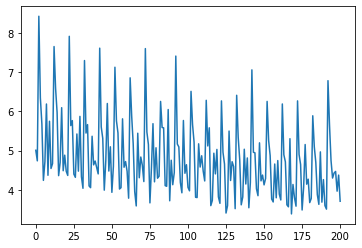

In [14]:
print(losses)
plt.plot(losses)

[DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), DiceLoss(), Dic

TypeError: ignored

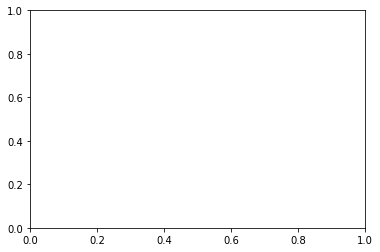

In [15]:


print(dice)
plt.plot(dice)

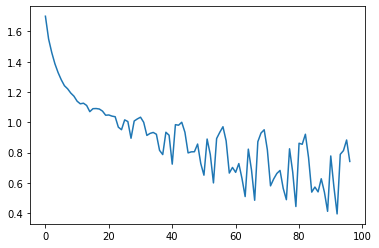

In [ ]:
import matplotlib.pyplot as plt 
ltss = [1.70007149, 1.55017629, 1.46012571, 1.38586426, 1.32799797, 1.28042561, 1.24131126, 1.22094918, 1.19285147, 1.17214563, 1.13913642, 1.12186573, 1.12582350, 1.11103916, 1.07005055, 1.08973023, 1.09067541, 1.08750767, 1.07370660, 1.04653341, 1.04813373, 1.04058532, 1.03661902, 0.96768056, 0.95085497, 1.01573747, 1.00472153, 0.89444307, 1.00830208, 1.02219700, 1.03340427, 0.99962615, 0.91318551, 0.92631605, 0.93283319, 0.92088048, 0.81446813, 0.78669451, 0.93398915, 0.91448539, 0.72355454, 0.98414133, 0.98059475, 1.00004644, 0.93411441, 0.79774205, 0.80468313, 0.80550831, 0.85616311, 0.72744804, 0.65063313, 0.88920223, 0.78781184, 0.59964559, 0.89257762, 0.93384923, 0.97049754, 0.87703078, 0.66458536, 0.70171241, 0.66942179, 0.72720473, 0.62868810, 0.50940357, 0.82252591, 0.68508252, 0.48494143, 0.87165433, 0.92885610, 0.95047871, 0.81849012, 0.58013723, 0.62571295, 0.66204723, 0.68204034, 0.56370130, 0.48878814, 0.82492138, 0.67093711, 0.44370449, 0.86142010, 0.85467242, 0.92090942, 0.76575264, 0.53885494, 0.57220260, 0.54031254, 0.62698207, 0.53827347, 0.41188918, 0.77752027, 0.57230932, 0.39483840, 0.78820457, 0.81270426, 0.88296388, 0.74129242]
plt.plot(ltss)

In [27]:
import numpy as np
test_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=1,
                                root_dir='/content/drive/MyDrive/ATLASSTUFF/split1/split1/train/')

model.eval()

x = 0
losses = []
for data, label in test_loader.load_batches():
        data = torch.Tensor(data)
        label = torch.Tensor(label)

        data, label = cubeView(data, label, 64, .3)
        data = data.to(device)
        label = label.to(device)

        outputs = model(data)
        loss = loss_func(outputs, label)

        # print statistics
        losses.append(loss.item())

print(np.mean(np.asarray(losses)))

0.6637054539862133


In [21]:

device = torch.device('cuda:0')
data, label = next(bids_loader.load_batches())

data = torch.Tensor(data)
label = torch.Tensor(label)


#data = downsize_64(data)
#label = downsize_64(label)
data, label = cubeView(data, label, 128, .6)

data = data.to(device)
label = label.to(device)

model.eval()

# only the deep learning part
with torch.no_grad():
  output = model(data)
print('Network output shape:', output.shape)

Network output shape: torch.Size([5, 1, 128, 128, 128])


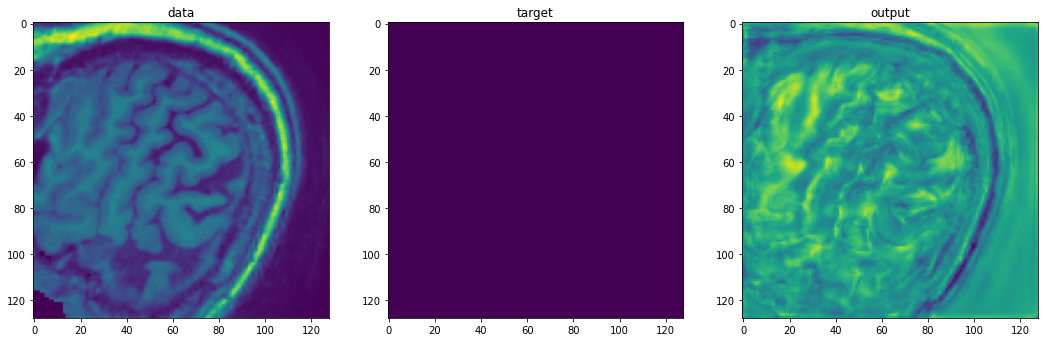

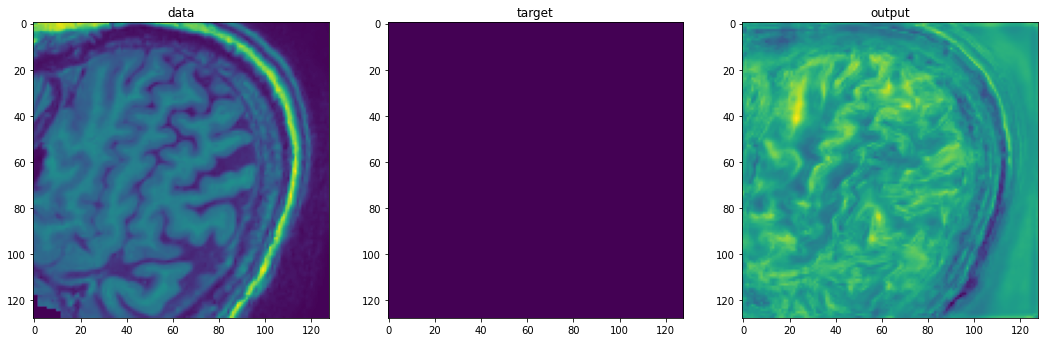

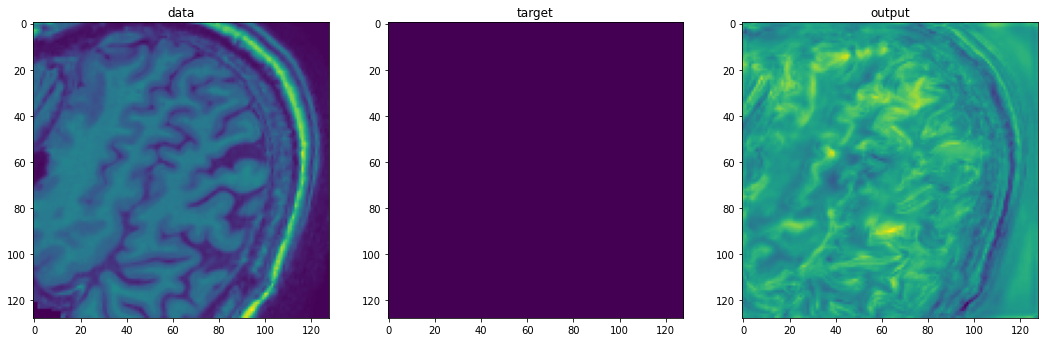

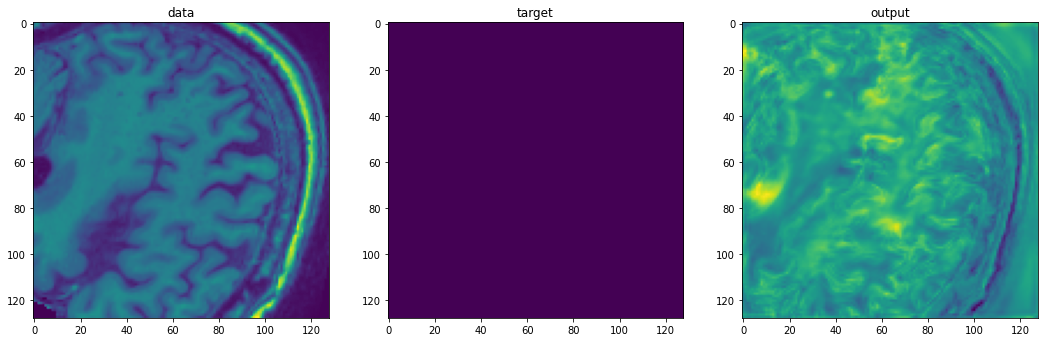

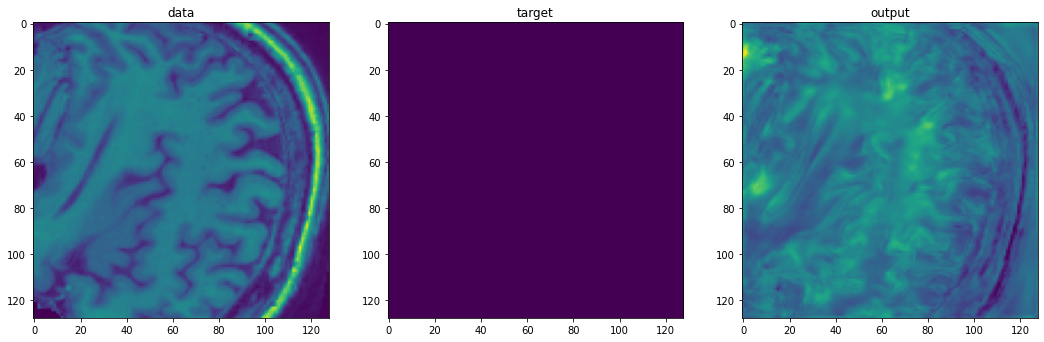

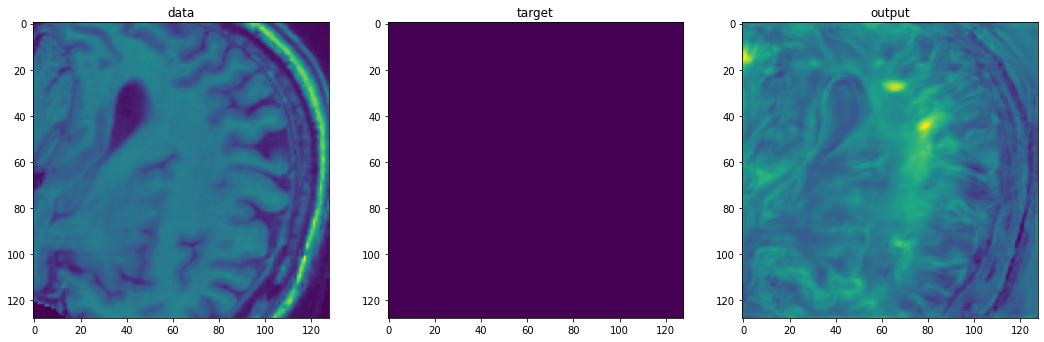

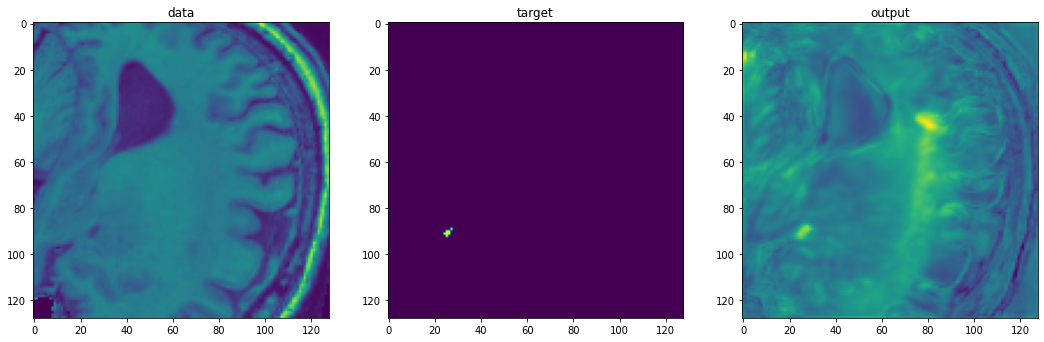

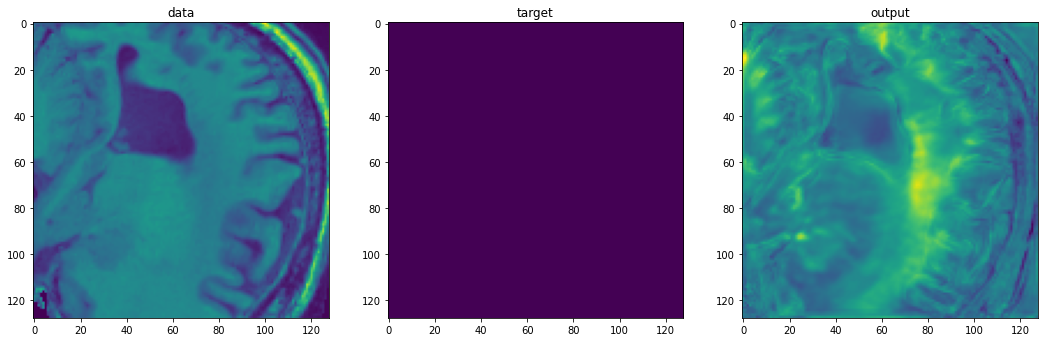

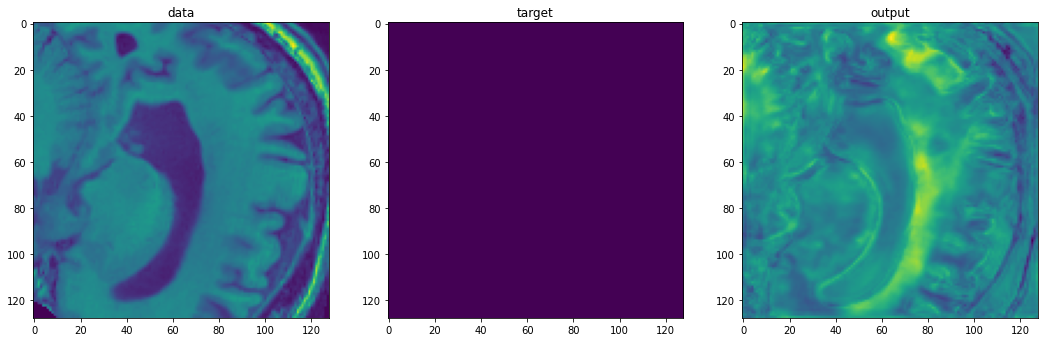

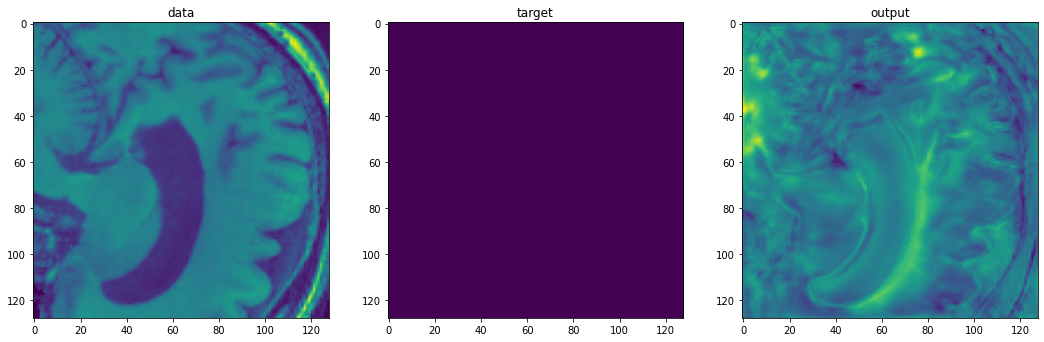

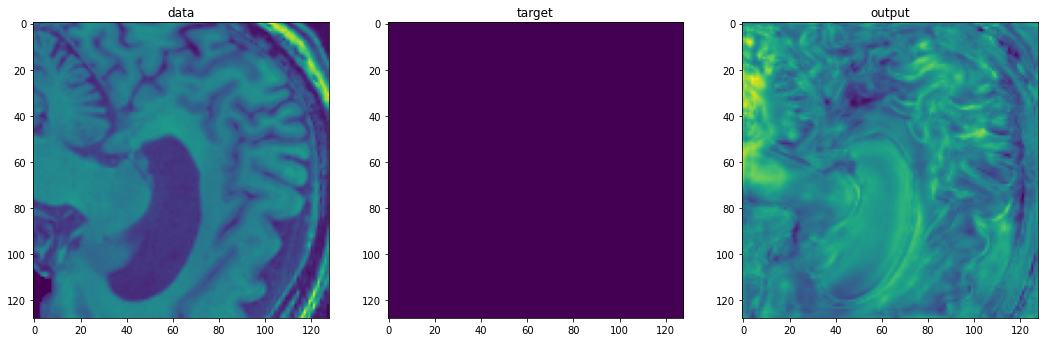

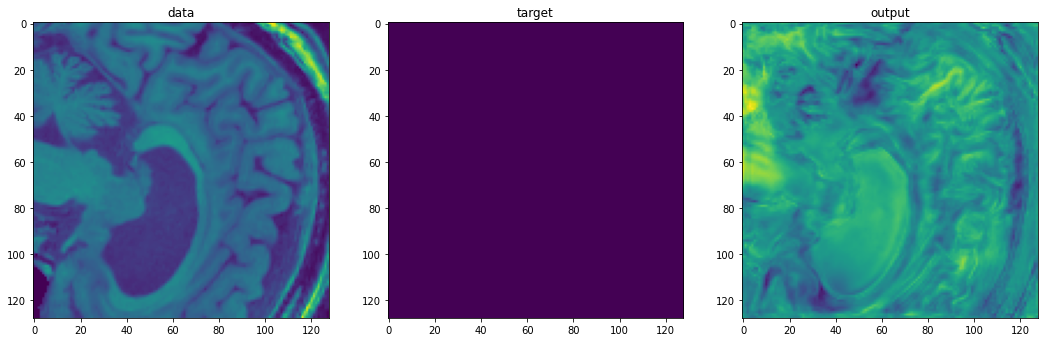

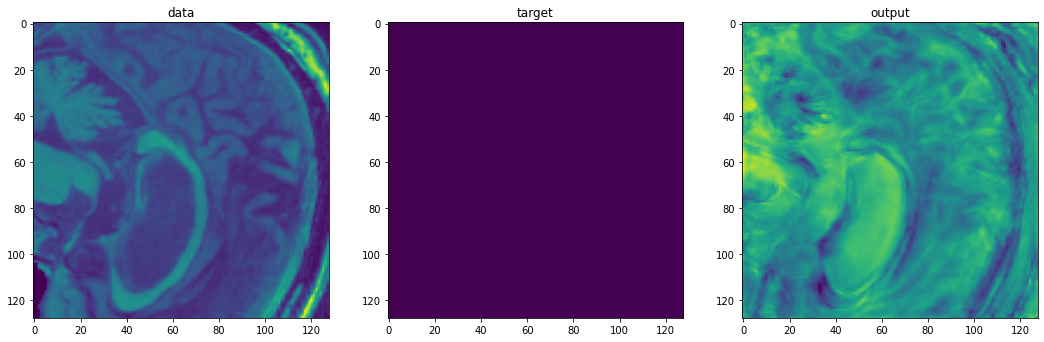

In [25]:
data = data.cpu()
label = label.cpu()
output = output.cpu()


for i in range(1,64,5):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,i]);plt.title('output')

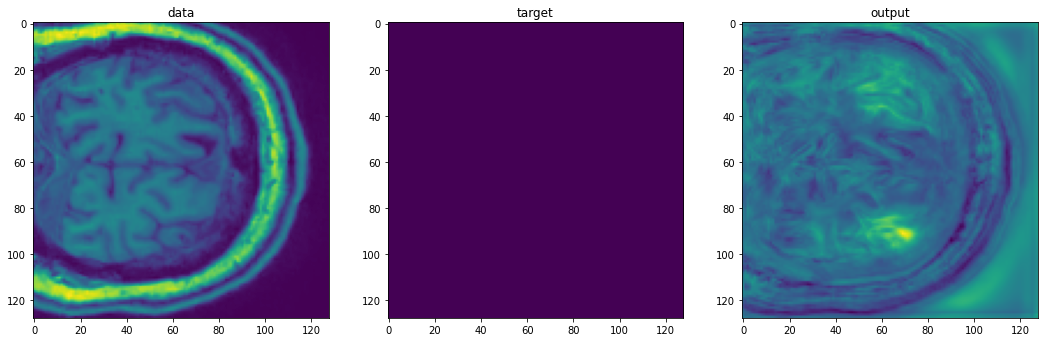

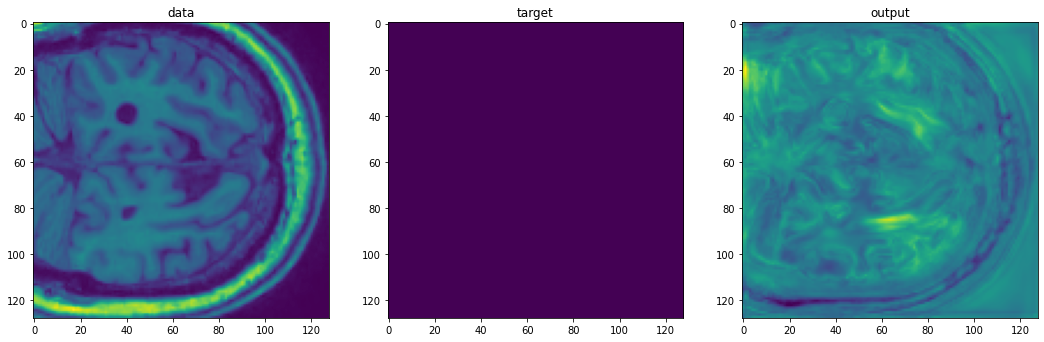

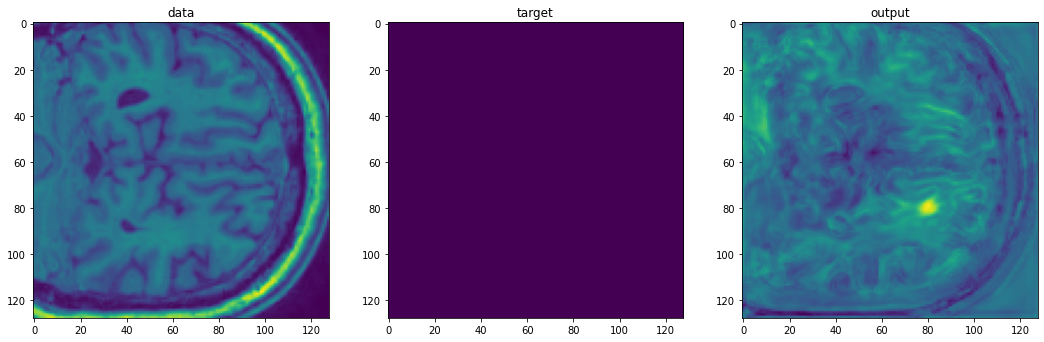

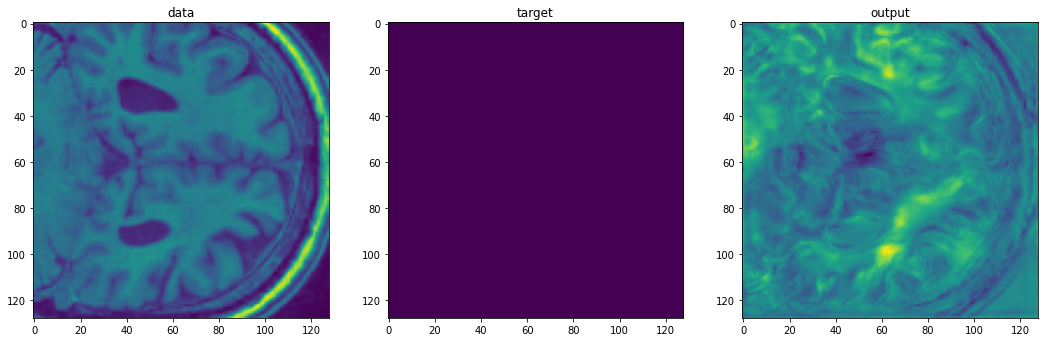

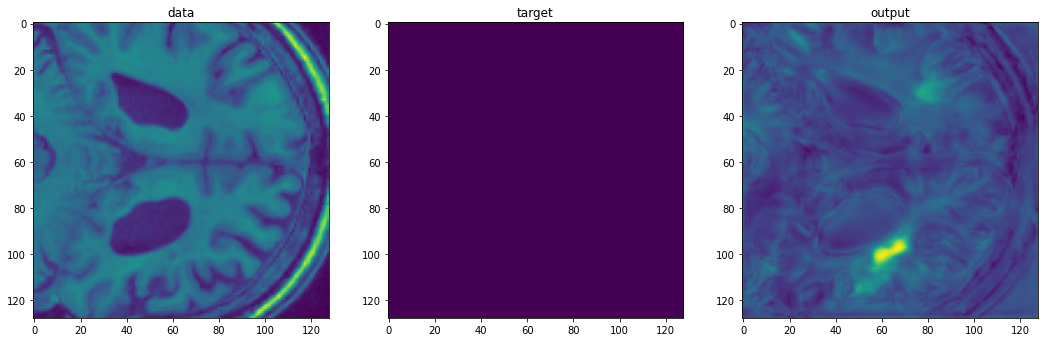

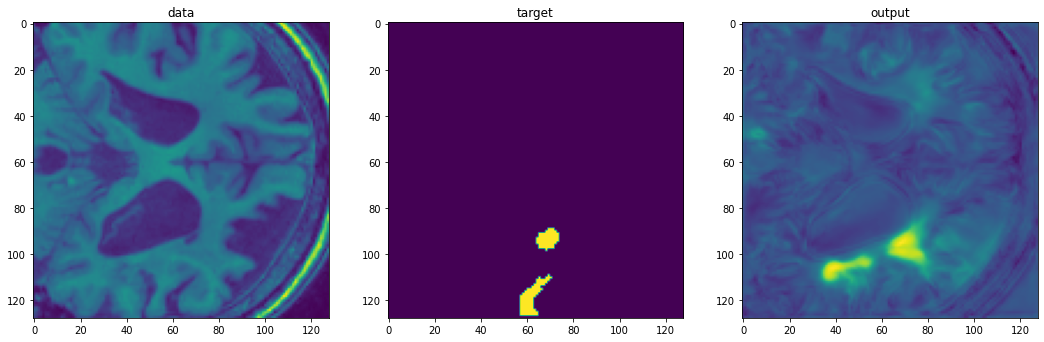

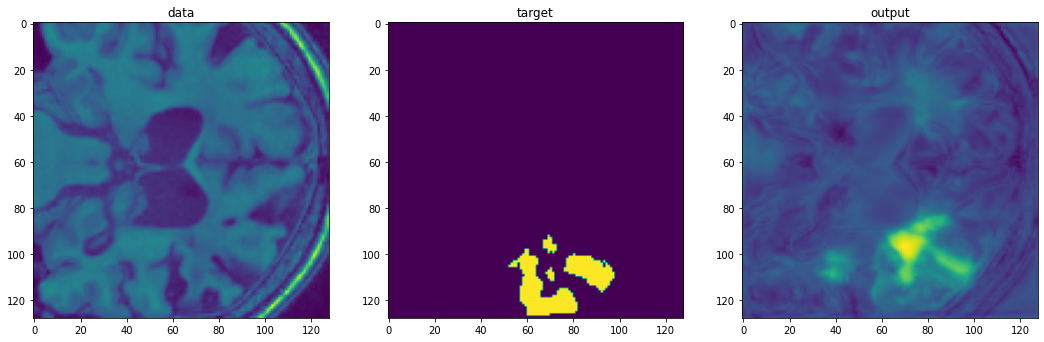

In [23]:
for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,:,i]);plt.title('output')

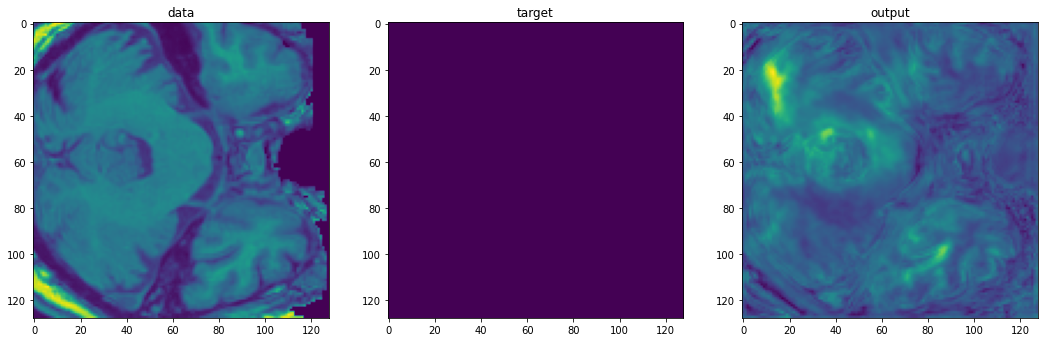

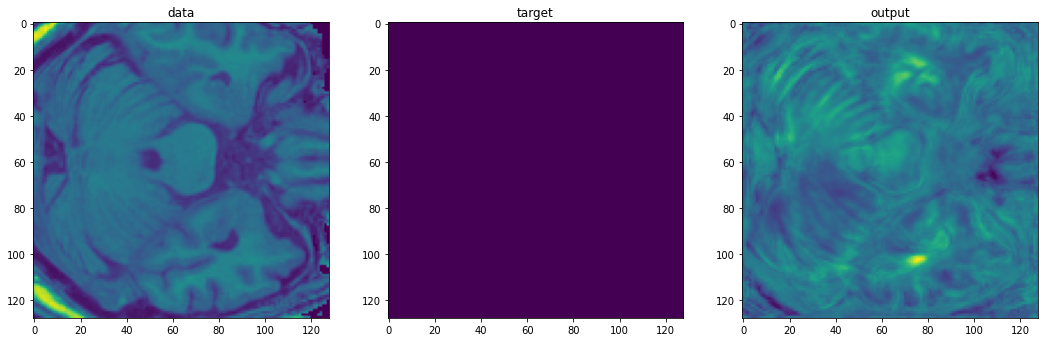

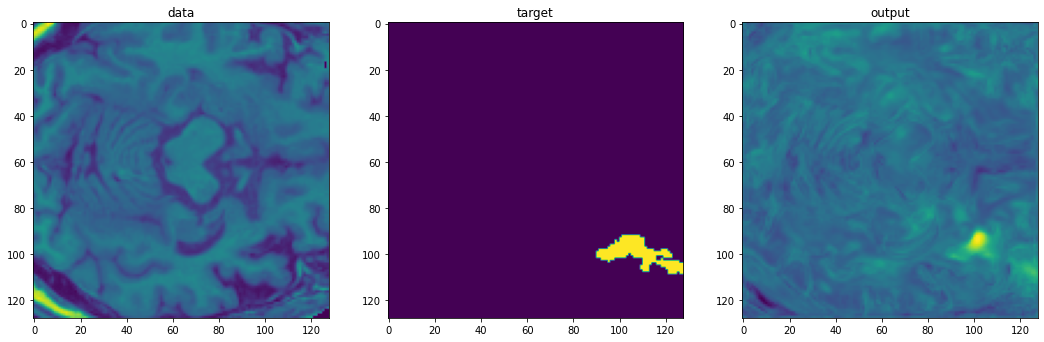

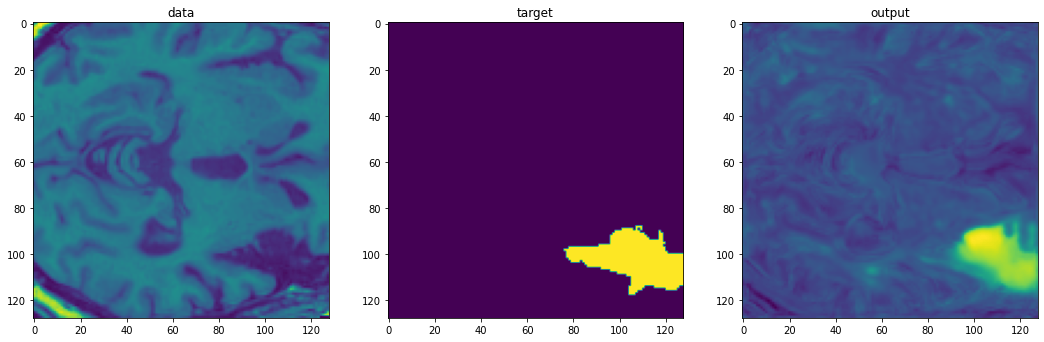

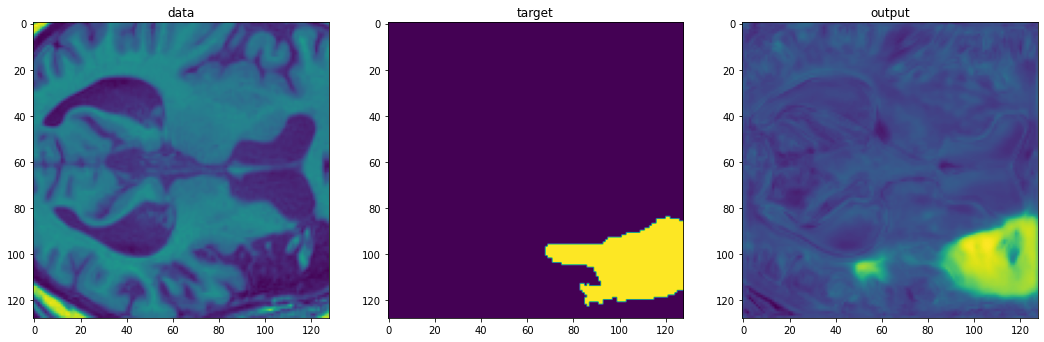

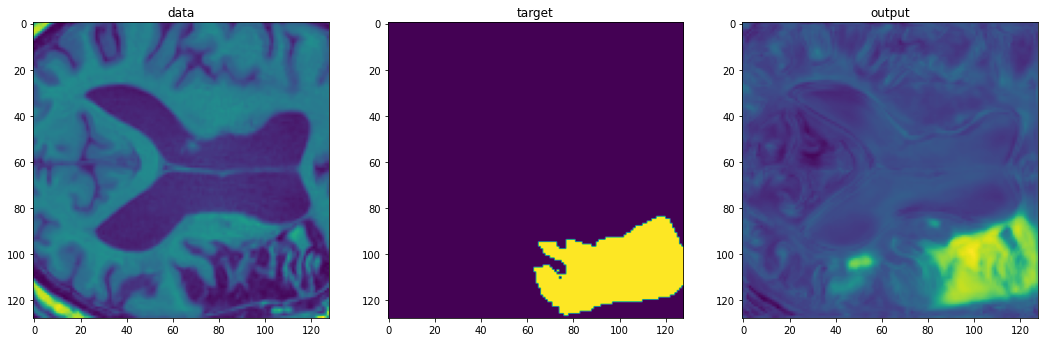

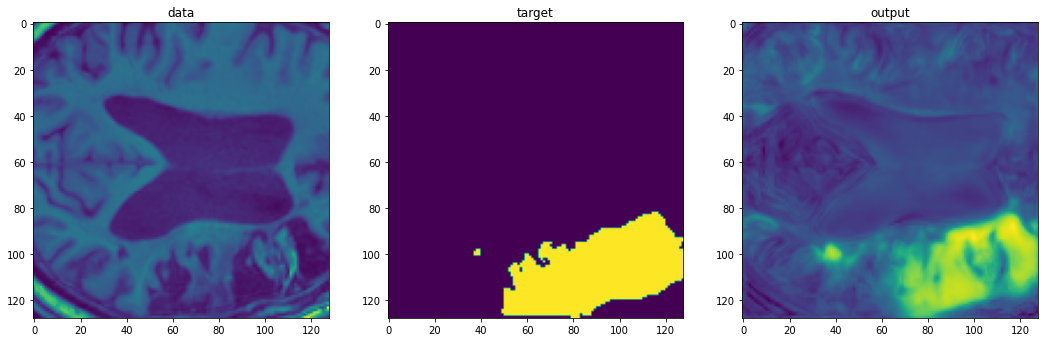

In [26]:
for i in range(1,64,10):
  plt.figure(figsize=(18, 8)) 
  plt.subplot(131)
  plt.imshow(data[0,0,:,:,i]);plt.title('data')
  plt.subplot(132)
  plt.imshow(label[0,0,:,:,i]);plt.title('target')
  plt.subplot(133)
  plt.imshow(output[0,0,:,:,i]);plt.title('output')

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/ATLASSTUFF/model_weights_osu3.pth')